#Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras.backend as K
from matplotlib import pyplot as plt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
import pubchempy as pcp
import datetime

Using TensorFlow backend.


In [3]:
git clone https://github.com/odifmonster/Final_Project.git
os.chdir('Final_Project/Data')

SyntaxError: invalid syntax (<ipython-input-3-dd4f9feff144>, line 1)

In [3]:
raw_data = pd.read_csv('raw_data.csv',header=None,names=['SMILES','LogP'])
raw_data.head()

,SMILES,LogP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


#Convert SMILES to InChi

In [0]:
def checkin(): # Checking in with progress :)
  if i % 1000 == 0:
    print(i, end='...')
  if (i > 0) and (i % 5000 == 0):
    print()

In [5]:
#mols dataframe
data = raw_data
for i in range(len(data)):
  compound = pcp.get_compounds(raw_data.iloc[i,0], namespace='smiles')[0]
  inchi = compound.inchi
  data.iloc[i,0] = inchi
  checkin()

0...1000...

In [6]:
data.head()

,SMILES,LogP
0,"InChI=1S/C4H8Cl2/c1-3(5)4(2)6/h3-4H,1-2H3/t3-,...",2.3
1,"InChI=1S/C3H6BrN/c4-2-1-3-5/h1-2H,3,5H2",0.3
2,"InChI=1S/C4H9BrO/c1-2-4(5)3-6/h4,6H,2-3H2,1H3",1.3
3,"InChI=1S/C6H14O/c1-2-3-4-5-6-7/h7H,2-6H2,1H3/i...",2.0
4,"InChI=1S/C5H13OP/c1-2-3-6-4-5-7/h2-5,7H2,1H3",0.6


#Bigram Dictionary

In [0]:
bigram_dict = {}

# Assigning bigrams to dictionary
for i in range(len(data)): # Iterating over compounds
  compound = data['SMILES'][i]
  bigrams = [zip(list(compound)[:-1], list(compound)[1:])][0]
  
  for b in bigrams: # Iterating over each bigram in compound
    bigram_dict.update({b:0})
    
features = np.ndarray(shape=(len(data), len(bigram_dict)))

# Custom dictionary per compound (counting occurences of bigrams)
for i in range(len(data)):
  # Assembling comp_dict
  comp_dict = bigram_dict.copy()
  compound = data.iloc[i,0]
  bigrams = [zip(list(compound)[:-1], list(compound)[1:])][0]
  
  for b in bigrams:
    comp_dict[b] += 1
    
  # Add to features vector
  features[i] = list(comp_dict.values())

#Splitting Data

In [0]:
labels = data['LogP'].values

# split to train & test data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

#split to train & validation data
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels)

#ANN

In [0]:
# RMSE for metrics
def rmse(y_true, y_pred):
  return K.sqrt(K.mean((y_true - y_pred) ** 2))

In [10]:
# -- Settings -- #
#        act drop loss l_r opt epochs
ann_d = [2,  0,   3,   2,  3,  1600]

#         0         1         2          3       4
activ = ['softmax','sigmoid','softplus','relu', 'linear'][ann_d[0]]
#don't use: softmax,

#          0   1   2    3
dropout = [0.1,0.2,0.3,.15][ann_d[1]]

loss = ['mean_squared_error',             # 0
        'mean_absolute_error',            # 1
        'mean_absolute_percentage_error', # 2
        'logcosh',                        # 3
        'poisson',                        # 4
        'cosine_proximity'][ann_d[2]]     # 5

#      0    1    2     3     4     5      6
l_r = [0.02,0.01,0.008,0.005,0.001,0.0005,0.0001][ann_d[3]]

optimizer = [tf.keras.optimizers.SGD(l_r),            # 0
             tf.keras.optimizers.RMSprop(l_r),        # 1
             tf.keras.optimizers.Adagrad(),           # 2
             tf.keras.optimizers.Adadelta(),          # 3
             tf.keras.optimizers.Adam(l_r)][ann_d[4]] # 4

#         0  1  2
#epochs = [60,80,100][ann_d[5]]
epochs = ann_d[5]

# -- Layers -- #
ann_model = tf.keras.Sequential()

ann_model.add(tf.keras.layers.Dense(512, activation=activ, name = 'Dense_1', input_shape=features[0].shape))
ann_model.add(tf.keras.layers.Dropout(dropout, name = 'Dropout_1'))

ann_model.add(tf.keras.layers.Dense(256, activation=activ, name = 'Dense_2'))
ann_model.add(tf.keras.layers.Dropout(dropout, name = 'Dropout_2'))

ann_model.add(tf.keras.layers.Dense(128, activation=activ, name = 'Dense_3'))
ann_model.add(tf.keras.layers.Dropout(dropout, name = 'Dropout_3'))

ann_model.add(tf.keras.layers.Dense(64, activation=activ, name = 'Dense_4'))
ann_model.add(tf.keras.layers.Dropout(dropout, name = 'Dropout_4'))

ann_model.add(tf.keras.layers.Dense(32, activation=activ, name = 'Dense_5'))
ann_model.add(tf.keras.layers.Dropout(dropout, name = 'Dropout_5'))

ann_model.add(tf.keras.layers.Dense(1, activation='linear', name = 'Output'))

# -- Compile -- #
ann_model.compile(loss=loss, optimizer=optimizer, metrics=[rmse])

print('Activation:', activ)
print('Dropout:   ', dropout)
print('Loss:      ', loss)
print('Optimizer: ', optimizer.__class__.__name__, 'w/ LR', l_r)
print('Epochs:    ', epochs)
ann_model.summary()

Activation: softplus
Dropout:    0.1
Loss:       logcosh
Optimizer:  Adadelta w/ LR 0.008
Epochs:     1600
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 512)               302592    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
Dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
Dropout_3 (Dropout)          (None, 128)               0         
___________________________________

In [0]:
history = ann_model.fit(train_features, train_labels,
                    epochs=1600, 
                    validation_split=0.2)

Train on 6573 samples, validate on 1644 samples
Epoch 1/1600
6573/6573 [==============================] - 3s 531us/step - loss: 0.5676 - rmse: 1.2898 - val_loss: 0.4217 - val_rmse: 1.0620
Epoch 2/1600
6573/6573 [==============================] - 3s 476us/step - loss: 0.3093 - rmse: 0.8882 - val_loss: 0.4019 - val_rmse: 1.0292
Epoch 3/1600
6573/6573 [==============================] - 3s 448us/step - loss: 0.2297 - rmse: 0.7484 - val_loss: 0.3652 - val_rmse: 0.9793
Epoch 4/1600
6573/6573 [==============================] - 3s 458us/step - loss: 0.1983 - rmse: 0.6866 - val_loss: 0.2109 - val_rmse: 0.7149
Epoch 5/1600
4352/6573 [==================>...........] - ETA: 1s - loss: 0.1799 - rmse: 0.65016573/6573 [==============================] - 3s 481us/step - loss: 0.1749 - rmse: 0.6394 - val_loss: 0.1342 - val_rmse: 0.5578
Epoch 6/1600
6573/6573 [==============================] - 3s 478us/step - loss: 0.1608 - rmse: 0.6097 - val_loss: 0.2455 - val_rmse: 0.7720
Epoch 7/1600
6573/6573 [======

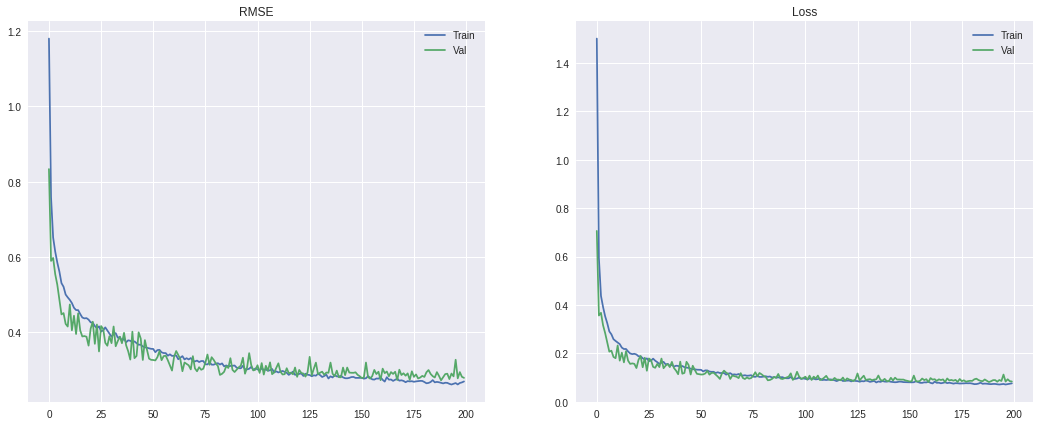

In [0]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(history.history['rmse'], label="Train")
plt.plot(history.history['val_rmse'], label="Val")
plt.title('RMSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.title('Loss')
plt.legend()
plt.show()

In [0]:
val_pred = ann_model.predict(val_features).reshape(len(val_features),)

#Evaluation

In [0]:
# RMSE
val_rmse = np.sqrt(((val_labels-val_pred) ** 2).mean())

# Data
compare = pd.DataFrame({'true':val_labels, 'pred':val_pred, 'error':abs(val_pred-val_labels)})

In [0]:
# Print Results
print("RMSE:", val_rmse)
print('Mean error:', compare['error'].mean(), '\n')
compare.head(10)

('RMSE:', 0.3151478755409372)
('Mean error:', 0.20518127337859493, '\n')


,error,pred,true
0,0.277945,0.722055,1.0
1,0.023997,2.576003,2.6
2,0.483341,-0.616659,-1.1
3,0.120437,0.179563,0.3
4,0.035521,0.564479,0.6
5,0.027903,0.772097,0.8
6,0.019483,1.880517,1.9
7,0.076010,-0.523990,-0.6
8,0.037254,1.862746,1.9
9,0.035984,0.335984,0.3
